# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")

# disable deprecations and future warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
!date

Tue Nov  7 23:01:16 UTC 2023


In [3]:
!cd ../crates/regression ; maturin develop -q --release

🔗 Found pyo3 bindings
🐍 Found CPython 3.11 at /opt/conda/bin/python
📡 Using build options features from pyproject.toml
📦 Built wheel for CPython 3.11 to /tmp/.tmpR2s6b2/regression-0.1.0-cp311-cp311-linux_aarch64.whl
🛠 Installed regression-0.1.0


In [4]:
import importlib 

import regression
importlib.reload(regression)

<module 'regression' from '/home/vscode/.local/lib/python3.11/site-packages/regression/__init__.py'>

# Data

In [56]:
# Generate some artificial data for regression
np.random.seed(42)
x = np.random.uniform(0, 10, size=100)
true_alpha, true_beta, true_sigma = 1, 2, 1
y = true_alpha + true_beta * x + np.random.normal(0, true_sigma, size=x.shape)


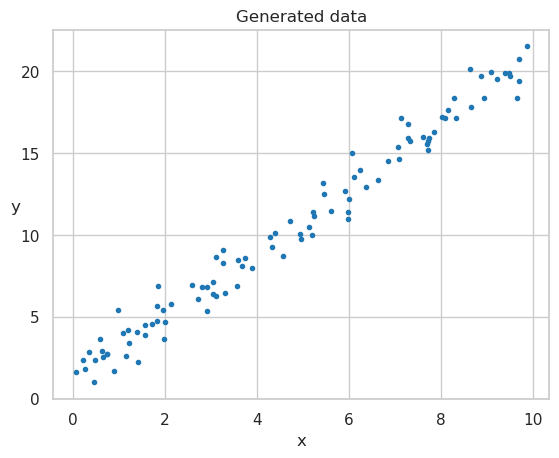

In [57]:
# plot the data
fig, ax = plt.subplots()
ax.plot(x, y, "C0.")
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.set_title("Generated data")
plt.show()

# Unormalized log density of the posterior distribution for a Bayesian linear regression model

In [58]:

# Define the log of the probability density function of a normal distribution
def log_pdf_normal(x, mean, sd):
    return -0.5 * np.log(2 * np.pi * sd**2) - 0.5 * ((x - mean) / sd)**2

# Define the log probability function for the Bayesian regression model
def bayesian_regression_logp(alpha, beta, sigma, x, y):
    # Ensure sigma is positive
    if sigma <= 0:
        return -np.inf
    
    # Priors for alpha and beta: Assuming they follow a normal distribution with mean 0 and standard deviation 10
    logp_alpha = log_pdf_normal(alpha, 0, 10)
    logp_beta = log_pdf_normal(beta, 0, 10)
    logp_sigma = 0 # uniform prior
    
    # Likelihood of the observed data y: Assuming it follows a normal distribution with mean mu and standard deviation sigma
    mu = alpha + beta * x
    logp_y = log_pdf_normal(y, mu, sigma)
    
    # Sum of all log probabilities (priors + likelihood)
    total_logp = logp_alpha + logp_beta + logp_sigma + logp_y.sum()
    return total_logp


# Rejection sampling

In [59]:
# Define a rejection sampling function
def rejection_sampling(logp_func, proposal_dist, x, y, num_samples, threshold):
    accepted_samples = []
    for _ in range(num_samples):
        # Sample from the proposal distribution
        sample = proposal_dist(1)[0]
        # Calculate the log probability of the sample
        sample_logp = logp_func(sample[0], sample[1], abs(sample[2]), x, y)
        # Uniformly sample a threshold value
        u = np.log(np.random.uniform(0, 1))
        # Accept or reject the sample based on the threshold
        if u < sample_logp - threshold:
            accepted_samples.append(sample)
    return np.array(accepted_samples)

# Find an appropriate threshold
# This is usually set to a value slightly less than the max of the logp function evaluations
# For the purpose of this example, we'll set it arbitrarily
threshold = np.max([bayesian_regression_logp(np.random.uniform(-5, 5), np.random.uniform(-5, 5), 
                                             np.random.uniform(0, 5), x, y) for _ in range(1000)]) - 10

# Proposal distribution generator function
def proposal_dist(num_samples):
    # Randomly sample alpha, beta, and sigma from assumed distributions
    # Here we are using normal distributions as proposal, which is not ideal
    # Normally we would use more informed distributions based on the problem
    alphas = np.random.normal(0, 5, num_samples)
    betas = np.random.normal(0, 5, num_samples)
    sigmas = np.abs(np.random.normal(0, 5, num_samples))  # sigma must be positive
    return np.vstack((alphas, betas, sigmas)).T

In [60]:
# Perform rejection sampling
num_samples = 100000 # This is the number of attempts, not the number of accepted samples
accepted_samples = rejection_sampling(
    bayesian_regression_logp, proposal_dist, x, y, num_samples, threshold
)

In [61]:
accepted_samples

array([[4.67617482e-01, 1.99224023e+00, 1.22702031e+00],
       [8.02537035e-04, 2.10663535e+00, 1.12701997e+00],
       [1.23058865e+00, 1.98133958e+00, 1.11431998e+00],
       [2.44754615e-01, 2.04463670e+00, 8.59589546e-01],
       [1.74062043e+00, 1.78164837e+00, 1.25337268e+00],
       [1.32650923e+00, 1.95087078e+00, 9.77660715e-01],
       [1.00055708e+00, 1.91997273e+00, 1.48606117e+00],
       [1.15993847e+00, 1.88977005e+00, 1.51156232e+00],
       [1.92643081e+00, 1.83726671e+00, 1.35137339e+00],
       [1.34835644e+00, 1.87992359e+00, 7.13366758e-01],
       [1.59170945e+00, 1.96260845e+00, 7.40577398e-01],
       [1.04026233e+00, 1.97690915e+00, 1.57324941e+00],
       [4.42348073e-01, 2.14229717e+00, 1.29388260e+00],
       [6.67367206e-01, 2.04752857e+00, 1.51805447e+00],
       [1.99369147e+00, 1.84584969e+00, 1.19060441e+00],
       [1.96042885e+00, 1.83940282e+00, 1.13759852e+00],
       [2.51788089e+00, 1.73296248e+00, 1.27841435e+00],
       [1.73443319e+00, 1.94923

In [62]:
df_rs = pd.DataFrame(accepted_samples, columns=["alpha", "beta", "sigma"])
df_rs.head()

,alpha,beta,sigma
0,0.467617,1.992240,1.227020
1,0.000803,2.106635,1.127020
2,1.230589,1.981340,1.114320
3,0.244755,2.044637,0.859590
4,1.740620,1.781648,1.253373


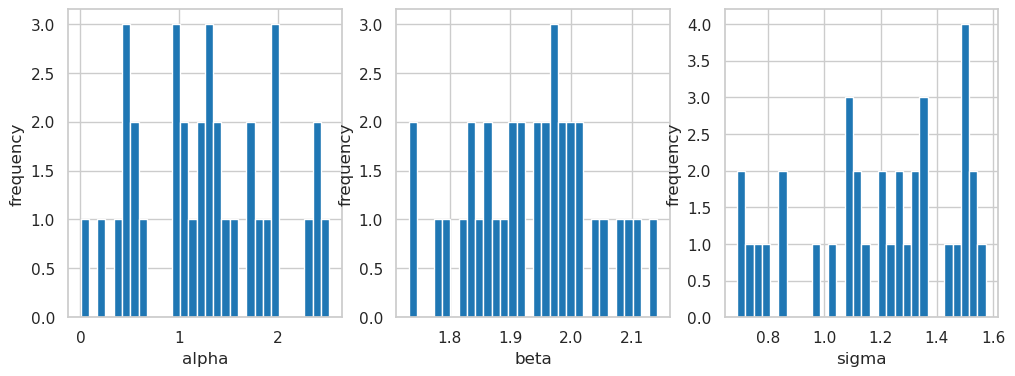

In [63]:
# Plot the posterior distributions of alpha, beta, and sigma
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(df_rs["alpha"], bins=30)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("frequency")
ax[1].hist(df_rs["beta"], bins=30)
ax[1].set_xlabel("beta")
ax[1].set_ylabel("frequency")
ax[2].hist(df_rs["sigma"], bins=30)
ax[2].set_xlabel("sigma")
ax[2].set_ylabel("frequency")
plt.show()

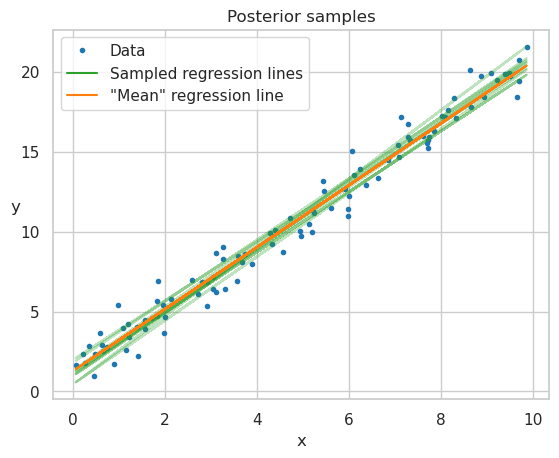

In [64]:
# plot the data and regression lines from the posterior samples
fig, ax = plt.subplots()

# plot the data
ax.plot(x, y, "C0.", label="Data")

# plot 10 lines from the posterior samples
for i in range(10):
    sample = df_rs.sample(1)
    alpha = sample["alpha"].values[0]
    beta = sample["beta"].values[0]
    sigma = sample["sigma"].values[0]
    mu = alpha + beta * x
    ax.plot(x, mu, "C2-", alpha=0.3)
# label the plot
plt.plot([], [], "C2-", label="Sampled regression lines")

# mean of the posterior distribution of alpha and beta
alpha_mean = df_rs["alpha"].mean()
beta_mean = df_rs["beta"].mean()
mu = alpha_mean + beta_mean * x
ax.plot(x, mu, "C1", label='"Mean" regression line')

plt.legend(loc="upper left")

ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.set_title("Posterior samples")
plt.show()


# Importance sampling

In [65]:

# Importance sampling function
def importance_sampling(logp_func, proposal_dist, x, y, num_samples):
    # Generate samples from the proposal distribution
    samples = proposal_dist(num_samples)
    
    # Evaluate the log probability of the target distribution at the samples
    logp_samples = np.array([logp_func(sample[0], sample[1], abs(sample[2]), x, y) for sample in samples])
    
    # Compute the weights for the samples
    weights = np.exp(logp_samples - max(logp_samples))
    weights /= np.sum(weights)
    
    return samples, weights

# Proposal distribution generator function
def proposal_dist(num_samples):
    # Randomly sample alpha, beta, and sigma from assumed distributions
    # Here we are using normal distributions as proposal, which is not ideal
    # Normally we would use more informed distributions based on the problem
    alphas = np.random.normal(0, 5, num_samples)
    betas = np.random.normal(0, 5, num_samples)
    sigmas = np.abs(np.random.normal(0, 5, num_samples))  # sigma must be positive
    return np.vstack((alphas, betas, sigmas)).T

In [66]:
# Perform importance sampling
num_samples = 5000
samples, weights = importance_sampling(
    bayesian_regression_logp, proposal_dist, x, y, num_samples
)
samples

array([[-7.05493362,  4.34758774,  3.06126099],
       [-3.79934251, -2.50609323,  4.19421289],
       [ 0.77107903, -4.72573094,  6.71156545],
       ...,
       [-2.64547989, -7.50109282,  2.06161903],
       [ 8.42404045, -4.82735108,  6.5405502 ],
       [-3.04717006,  3.14306126,  6.78724211]])

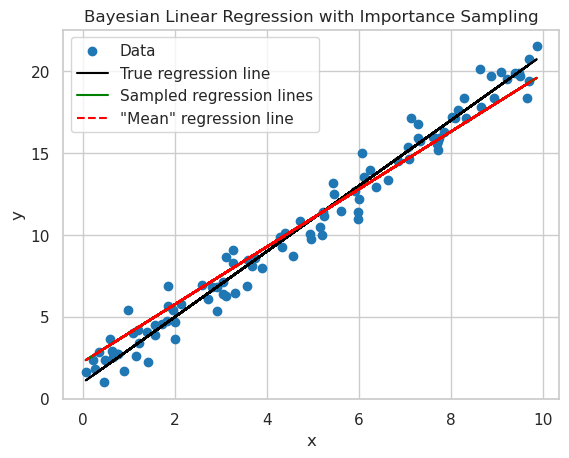

In [67]:
# Compute weighted estimates for alpha, beta, and sigma
alpha_est = np.sum(weights * samples[:, 0])
beta_est = np.sum(weights * samples[:, 1])
sigma_est = np.sqrt(np.sum(weights * (samples[:, 2]**2)))

# Plot the artificial data
plt.scatter(x, y, label='Data')

# Plot the true regression line
plt.plot(x, true_alpha + true_beta * x, 'k', label='True regression line')


# sampled regression lines
for i in range(10):
    sample = samples[np.random.choice(num_samples, p=weights)]
    alpha = sample[0]
    beta = sample[1]
    sigma = sample[2]
    plt.plot(x, alpha + beta * x, 'g', alpha=0.3)
plt.plot([], [], 'g', label='Sampled regression lines')

# Plot the estimated regression line
plt.plot(x, alpha_est + beta_est * x, 'r--', label='"Mean" regression line')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with Importance Sampling')
plt.legend()
plt.show()

# Metropolis Hastings

In [68]:
def metropolis_hastings(logp_func, initial_params, proposal_std, x, y, num_samples):
    """
    Metropolis-Hastings sampler for Bayesian regression parameters.

    :param logp_func: Function to compute log-probability of the target distribution.
    :param initial_params: Starting parameter values for the sampler.
    :param proposal_std: Standard deviation for the proposal distribution.
    :param x: Observed data for the predictor variable.
    :param y: Observed data for the response variable.
    :param num_samples: Number of samples to draw.
    :return: Array of sampled parameter values.
    """
    # Initialize the chain with the initial parameters
    current_params = np.array(initial_params)
    current_logp = logp_func(*current_params, x, y)
    
    # Array to hold the samples
    samples = np.zeros((num_samples, len(initial_params)))
    
    for i in range(num_samples):
        # Propose new parameters by adding normal random values
        proposed_params = current_params + np.random.normal(0, proposal_std, len(initial_params))
        # Ensure sigma is positive
        proposed_params[2] = abs(proposed_params[2])
        proposed_logp = logp_func(*proposed_params, x, y)
        
        # Acceptance probability
        acceptance_prob = min(1, np.exp(proposed_logp - current_logp))
        
        # Accept or reject the new parameters
        if np.random.rand() < acceptance_prob:
            current_params = proposed_params
            current_logp = proposed_logp
        
        samples[i] = current_params
    
    return samples

In [69]:
# Initial parameters for the sampler
initial_params = [1, 1, 1]

# Standard deviation for the proposal distribution
proposal_std = [2., 2., 2.]

# Number of samples to draw
num_samples = 500000

# Run the Metropolis-Hastings sampler
mh_samples = metropolis_hastings(
    bayesian_regression_logp, initial_params, proposal_std, x, y, num_samples
)

# Burn-in and thinning
burn_in = int(num_samples * 0.1)
thinned_samples = mh_samples[burn_in::3]

# Estimate the parameters using the mean of the sampled values
mh_alpha_est = np.mean(thinned_samples[:, 0])
mh_beta_est = np.mean(thinned_samples[:, 1])
mh_sigma_est = np.mean(thinned_samples[:, 2])

In [70]:
df_mh = pd.DataFrame(thinned_samples, columns=['alpha', 'beta', 'sigma'])
df_mh.head()

,alpha,beta,sigma
0,1.206822,1.962435,0.871625
1,1.206822,1.962435,0.871625
2,1.206822,1.962435,0.871625
3,1.206822,1.962435,0.871625
4,1.206822,1.962435,0.871625


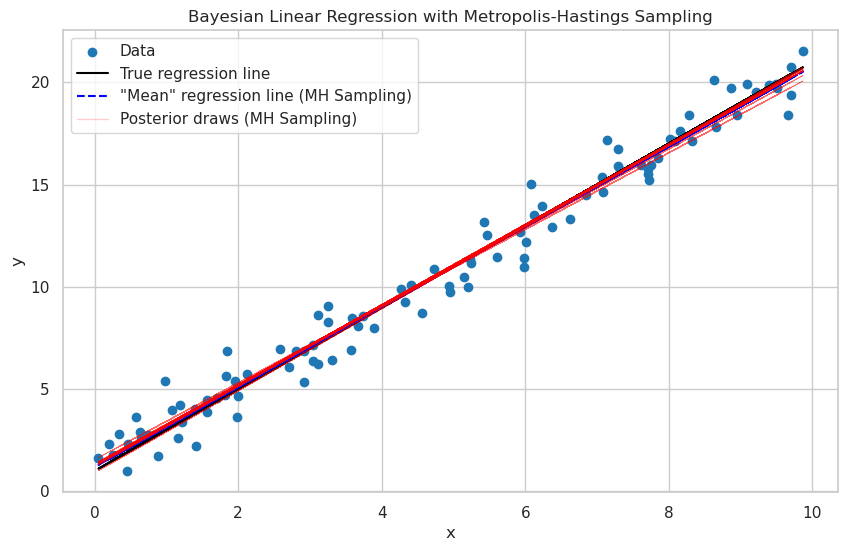

In [71]:
fig = plt.figure(figsize=(10, 6))
# Plot the artificial data
plt.scatter(x, y, label='Data')

# Plot the true regression line
plt.plot(x, true_alpha + true_beta * x, 'k', label='True regression line')

# Plot the estimated regression line from Metropolis-Hastings sampling
plt.plot(x, mh_alpha_est + mh_beta_est * x, 'b--', label='"Mean" regression line (MH Sampling)')

# Plot sample regression lines from Metropolis-Hastings sampling
for i in range(10):
    idx = np.random.randint(len(thinned_samples))
    alpha = thinned_samples[idx, 0]
    beta = thinned_samples[idx, 1]
    plt.plot(x, alpha + beta * x, 'r', alpha=0.6, lw=0.5)
# add posterior mean line to the legend
plt.plot([], [], 'r', alpha=0.2, lw=1, label='Posterior draws (MH Sampling)')


plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with Metropolis-Hastings Sampling')
plt.legend()
plt.show()



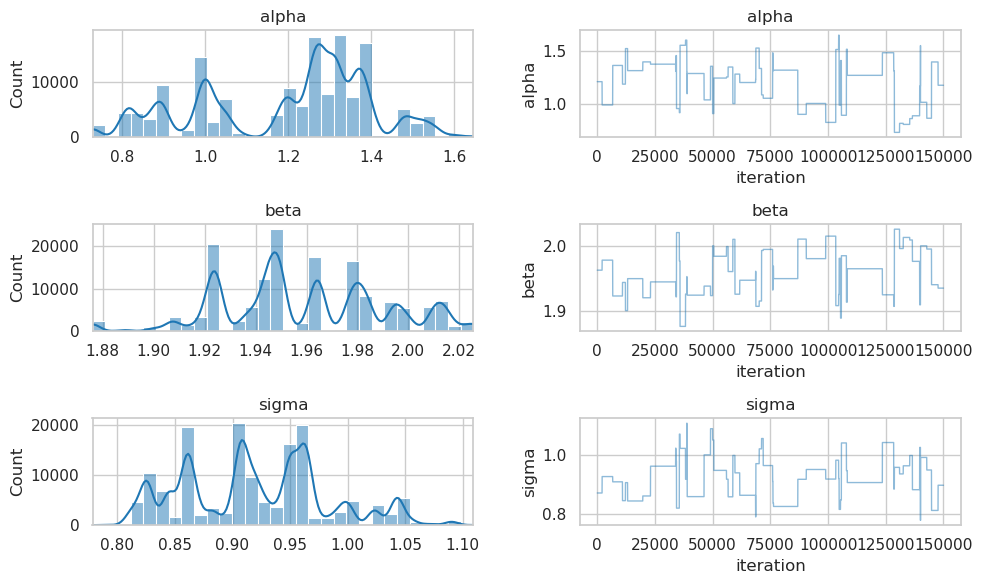

In [72]:
# Plot the histograms and traces for each parameter
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, v in enumerate(['alpha', 'beta', 'sigma']):
    sns.histplot(df_mh, x=v, bins=30, ax=axes[i, 0], kde=True)
    # xlim
    axes[i, 0].set_xlim(df_mh[v].min(), df_mh[v].max())
    axes[i, 0].set_title(v)
    axes[i, 0].set_xlabel("")

    # plot traces
    sns.lineplot(data=df_mh, x=df_mh.index, y=v, ax=axes[i, 1], linewidth=1, alpha=0.5)
    axes[i, 1].set_title(v)
    axes[i, 1].set_xlabel("iteration")
plt.tight_layout()
plt.show()

# NUTS

For more details on the log density function used in this example, see `Regression::logp()` in [../crates/regression/src/lib.rs].

In [73]:
help(regression.run_regression)

Help on built-in function run_regression in module regression.regression:

run_regression(x, y, chain_count, tuning, samples, seed, initial_position)
    Run the regression.



In [74]:
res = regression.run_regression(x, y, 4, 1000, 1000, 42, [1., 1., 1.])

res = {k: {f"chain_{c}": d for c, d in enumerate(v)} for k, v in res.items()}

df = pd.DataFrame(res)
df

,sigma,alpha,beta
chain_0,"[0.8876171060028945, 0.9145788581403643, 0.939...","[1.1130095262648274, 1.2623593052769855, 1.277...","[1.9708654560703787, 1.9540994054360457, 1.976..."
chain_1,"[0.8866658477318791, 0.8668118683011771, 0.913...","[1.2096936161564757, 1.4625585340106433, 1.411...","[1.9638880307546636, 1.9006727628360196, 1.890..."
chain_2,"[0.8214228444050435, 0.8061669059806182, 0.936...","[1.0641595411148823, 1.0671534466550048, 1.190...","[1.973474472118609, 1.970046621230703, 1.98581..."
chain_3,"[0.9710228027625399, 0.9432513717222427, 0.967...","[1.0031786586547677, 1.398930292349835, 1.2126...","[1.973691508302231, 1.9146558959315099, 1.9463..."


In [75]:
# explode the lists
df_ = df.apply(pd.Series.explode).reset_index().rename({'index': 'chain'}, axis=1)
df_

,chain,sigma,alpha,beta
0,chain_0,0.887617,1.11301,1.970865
1,chain_0,0.914579,1.262359,1.954099
2,chain_0,0.939525,1.277046,1.976068
3,chain_0,0.862395,1.3046,1.967211
4,chain_0,0.868155,1.287734,1.965543
...,...,...,...,...
3995,chain_3,0.888508,1.16607,1.95699
3996,chain_3,0.819881,1.349881,1.93328
3997,chain_3,0.935438,1.264264,1.940141
3998,chain_3,0.922124,1.211594,1.977049


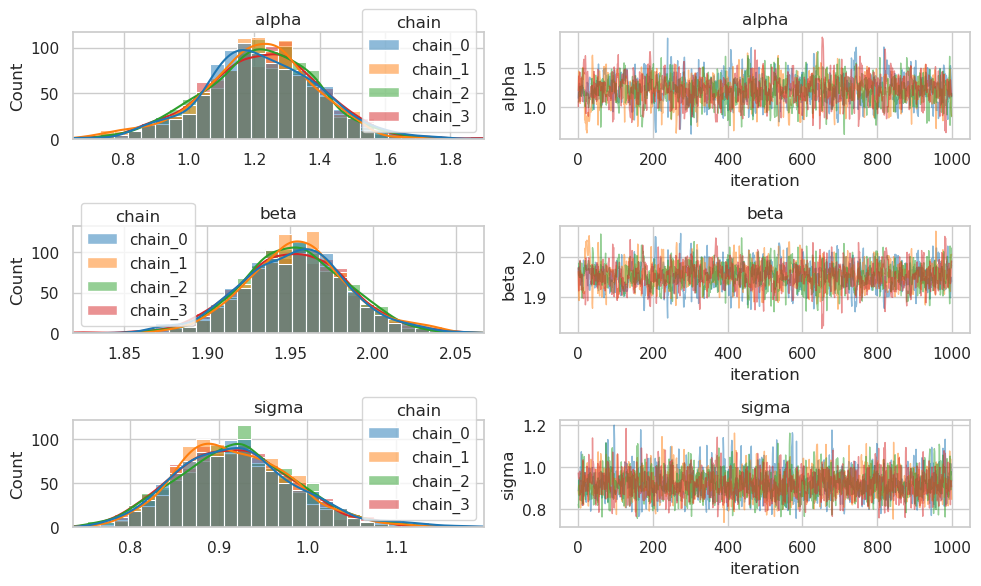

In [76]:
# plot histograms and traces for each parameter and each chain
fig, axes = plt.subplots(3, 2, figsize=(10, 6))

for i, v in enumerate(['alpha', 'beta', 'sigma']):
    sns.histplot(df_, x=v, bins=30, hue='chain', ax=axes[i, 0], kde=True)
    # xlim
    axes[i, 0].set_xlim(df_[v].min(), df_[v].max())
    axes[i, 0].set_title(v)
    axes[i, 0].set_xlabel("")

    # plot traces
    for c in df_['chain'].unique():
        df__ = df_.query(f"chain == '{c}'").copy()
        df__ = df__.reset_index(drop=True).reset_index()
        sns.lineplot(data=df__, x='index', y=v, ax=axes[i, 1], linewidth=1, alpha=0.5)
    axes[i, 1].set_title(v)
    axes[i, 1].set_xlabel("iteration")
plt.tight_layout()
plt.show()

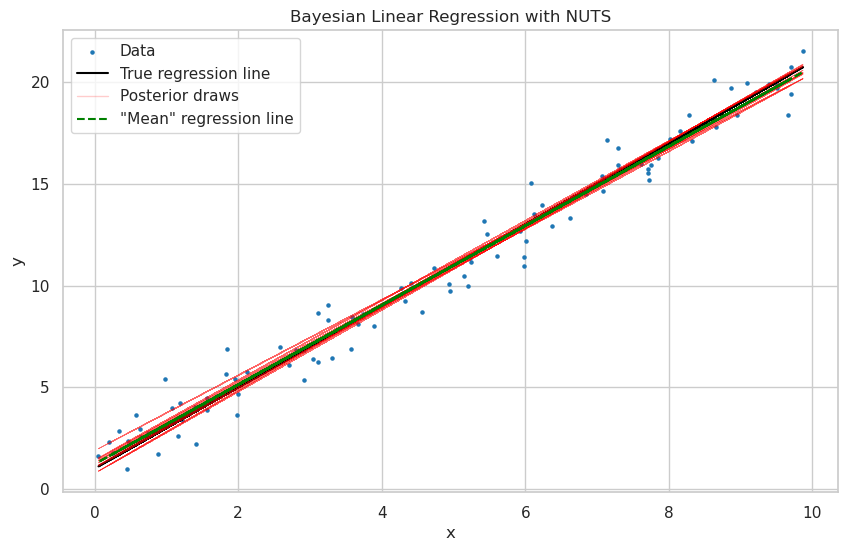

In [77]:
# Compute stimates for alpha, beta, and sigma
alpha_est = df_["alpha"].mean()
beta_est = df_["beta"].mean()
sigma_est = df_["sigma"].mean()

fig = plt.figure(figsize=(10, 6))

# Plot the artificial data
plt.scatter(x, y, label='Data', s=5)

# Plot the true regression line
plt.plot(x, true_alpha + true_beta * x, 'k', label='True regression line')

# plot 20 lines from the posterior distribution
for i in range(10):
    idx = np.random.randint(len(df_["alpha"]))
    alpha = df_["alpha"].iloc[idx]
    beta = df_["beta"].iloc[idx]
    plt.plot(x, alpha + beta * x, 'r', alpha=0.6, lw=0.5)
# add posterior mean line to the legend
plt.plot([], [], 'r', alpha=0.2, lw=1, label='Posterior draws')

# Plot the estimated regression line
plt.plot(x, alpha_est + beta_est * x, 'g--', label='"Mean" regression line')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression with NUTS')
plt.legend()
plt.show()

In [78]:
!date

Tue Nov  7 23:04:13 UTC 2023
